# Kitchen20: an extention to ESC50


The Kitchen20 dataset is a freely available (Creative Commons Attribution-NonCommercial license) collection of short kitchen sounds recordings presented in a unified format (5-second-long clips, 44100 Hz, single channel, compressed @ 192 kbit/s). All clips have been extracted and manually labeled by the author from public field recordings available through bothe the Freesound.org project and diverse participant that agreed on recording specific sounds in their own kitchens.

- Kitchen20: a sound dataset with 800 environmental sounds (20 classes, 40 clips per class)
- ESC70: The concatenation of both ESC50 and Kitchen20

---

The goal of this project is to include specific sounds that would happen in a kitchen to a raw audio dataset of environmental sounds.

This notebook provides a glipse into data.

## Loading the Data:

In [1]:
import os
import shutil
import urllib
import zipfile
import glob
import pandas as pd
import numpy as np
import kitchen20
from kitchen20 import esc

np.random.seed(1234)
datasets = [
            esc.ESC70(folds=[1, 2, 3, 4, 5],
                      compute_features=True,
                      audio_rate=44100),
            esc.ESC50(folds=[1, 2, 3, 4, 5],
                      compute_features=True,
                      audio_rate=44100),
            esc.ESC10(folds=[1, 2, 3, 4, 5],
                      compute_features=True,
                      audio_rate=44100),
            esc.Kitchen20(folds=[1, 2, 3, 4, 5],
                          compute_features=True,
                          audio_rate=44100)]

dataset = datasets[0]

/media/moreaux-gpu/Data1/Dataset/ESC-70/kitchen20/__init__.py
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...
loading  fold1
loading  fold2
loading  fold3
loading  fold4
loading  fold5
Computing features...


In [2]:
def dataset_to_df(dataset):
    '''Get a dataframe out of the dataset.
    The dataframe contains MFCC's means and variance values over the full lenght
    of the sound on 13 different banks and the zero crossing rate mean and variance'''
    df  = pd.DataFrame()
    for idx, values in enumerate(zip(dataset.folds_nb, 
                                     dataset.labels, 
                                     dataset.mfcc, 
                                     dataset.zcr)):
        fold, label, mfcc, zcr = values
        row = pd.DataFrame([idx], columns=['idx'])
        row['fold'], row['category'] = fold, label

        # Compute mean and std of the banks in mfcc
        mfcc = mfcc[:, :]
        mfcc_mean = pd.DataFrame(np.mean(mfcc, axis=0)[1:]).T
        mfcc_mean.columns = list('MFCC_{} mean'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
        mfcc_std = pd.DataFrame(np.std(mfcc, axis=0)[1:]).T
        mfcc_std.columns = list('MFCC_{} std'.format(i) for i in range(np.shape(mfcc)[1]))[1:]
        row = row.join(mfcc_mean)
        row = row.join(mfcc_std)

        # Compute mean and std of zcr
        row['ZCR mean'] = np.mean(zcr)
        row['ZCR std'] = np.std(zcr)

        df = df.append(row)
        
    return df

df = None

## Confusion matrix code

In [3]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots(figsize=(10,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## Bayesian process' functions
find the best set of parameters with a bayesian process method

In [5]:
import sklearn as sk
import sklearn.ensemble
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt
from sklearn.model_selection import cross_val_score

class BaysianLearning:
    '''Start a baysian learning on a given learning space'''
    
    fStart = 'MFCC_1 mean'
    fEnd = 'ZCR std'

    def __init__(self, df, clf, space, n_iteration=100):
        self.df = df
        self.clf = clf
        self.space = space
        self.n_iteration = n_iteration
        self.df_results = pd.DataFrame()
    
    def __repr__(self):
        return 'Bayesian {} with {}'.format(
            self.__str__,
            ', '.join(self.space.keys()))
    
    def __str__(self):
        if self.clf.__name__ == 'SVC':
            return 'SVM'
        if self.clf.__name__ == 'RandomForestClassifier':
            return 'RF'
        if self.clf.__name__ == 'KNeighborsClassifier':
            return 'KNN'
    
    def train(self, fold):
        X = df[df['fold'] != fold].loc[:, self.fStart: self.fEnd]
        Y = df[df['fold'] != fold]['category']
        return X, Y

    def test(self, fold):
        X = df[df['fold'] == fold].loc[:, self.fStart: self.fEnd]
        Y = df[df['fold'] == fold]['category']
        return X, Y
    
    def run(self):
        trials = Trials()
        best = fmin(self.loss,
                    space=self.space,
                    algo=tpe.suggest,
                    max_evals=self.n_iteration,
                    trials=trials)

    def loss(self, space):
        acc = self.classify_all_folds(space)
        return {'loss': -acc, 'status': STATUS_OK}

    def classify_all_folds(self, space):
        local_accs = []
        for fold in range(1, 6):
            acc, pred = self.classify_fold(fold, space)
            self.df_results = self.df_results.append({
                    'fold': fold,
                    'accuracy': acc,
                    'pred': pred,
                    'name': str(self),
                    **space
                }, ignore_index=True)
            local_accs.append(acc)
        
        local_acc_mean = np.array(local_accs).mean()
        self.df_results = self.df_results.append({
                'fold': -1,
                'accuracy': local_acc_mean,
                'name': str(self),
                **space
            }, ignore_index=True)
        return local_acc_mean

    def classify_fold(self, fold, space):        
        X_train, Y_train = self.train(fold)
        X_test, Y_test = self.test(fold)
        
        # Fit classifier and retrieve test accuracy
        clf = self.clf(**space)
        clf.fit(X_train, Y_train)
        pred = clf.predict(X_test)
        acc = np.sum(Y_test == pred) / float(len(pred))
        return acc, pred
    
    def best_algo(self):
        best_idx = self.df_results[self.df_results.fold == -1]['accuracy'].idxmax()
        return self.df_results[best_idx - 5: best_idx + 1]


    
def get_bayesian_args():
    bayesian_args = [
        {
            'clf': sk.neighbors.KNeighborsClassifier,
            'space': {'n_neighbors': scope.int(hp.uniform('n_neighbors', 1, 300))},
        },{
            'clf': sk.ensemble.RandomForestClassifier,
            'space': {
                'n_estimators': scope.int(hp.uniform('n_estimators', 1, 1000)),
                'max_features': scope.int(hp.uniform('max_features', 1, 10)),
                'max_depth': scope.int(hp.uniform('max_depth', 1, 20)),
                'criterion': hp.choice('criterion', ["gini", "entropy"])},
        }, {
            'clf': sk.svm.SVC,
            'space': {
                'kernel': 'linear',
                'C': hp.uniform('C', 0, 10.0),
                'gamma': hp.uniform('gamma', 0, 20.0)},
        }]
    return bayesian_args


def train_all_bayesian(df, n_iteration=200):
    best_algos = pd.DataFrame()
    for args in get_bayesian_args():
        a = BaysianLearning(df, **args, n_iteration=200)
        a.run()
        best_algos = best_algos.append(a.best_algo(),
                                       ignore_index=True)
    return best_algos

## Find best parameters by hand

In [6]:
import sklearn as sk
import sklearn.ensemble

df_results = pd.DataFrame(columns=['f1','f2','f3','f4','f5'])
features_start = 'MFCC_1 mean'
features_end = 'ZCR std'

def train_on(algo_name, train, test):
    # Choose classifier
    if algo_name.startswith('knn'):
        n_neighbors = int(algo_name.split('_')[1])
        classifier = sk.neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    
    elif algo_name.startswith('RandomForest'):
        n_estimators = int(algo_name.split('_')[1])
        classifier = sk.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    
    elif algo_name.startswith('SVM'):
        c = float(algo_name.split('_')[1])
        kernel = algo_name.split('_')[2]
        classifier = sk.svm.SVC(C=c, kernel=kernel)
    
    else:
        print('Wrong algorithm name: ', algo_name)

    classifier.fit(train.loc[:, features_start:features_end], train['category'])
    test.loc[:, 'prediction'] = classifier.predict(test.loc[:, features_start:features_end])
    accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
    confusion_mat = sk.metrics.confusion_matrix(test['category'], test['prediction'])

    return accuracy, confusion_mat


def record_confusions(confusion_matrix, confusions, algo_name):
    if algo_name not in confusions.keys():
        print(algo_name, confusion_matrix.shape)
        confusions[algo_name] = np.zeros(confusion_matrix.shape, dtype=int)
    confusions[algo_name] = confusions[algo_name] + confusion_matrix
    return confusion


def train_5_folds(df):
    df_results = pd.DataFrame(columns=['f1','f2','f3','f4','f5'])
    confusions = {}
    for fold in range(1, 6):
        print('Training fold', fold)
        df_column = 'f{}'.format(fold)
        train = df[df['fold'] != fold].copy()
        test = df[df['fold'] == fold].copy()
    
        print('train knn')
        for i in range(1,13):
            df_line = algo_name = 'knn_{}'.format(i)
            accuracy, confusion_current = train_on(algo_name, train, test)
            df_results.loc[df_line, df_column] = accuracy
            confusions['{}_{}'.format(algo_name, fold)] = confusion_current

        print('train random forest')
        for i in [300, 400, 500, 600, 700]:
            df_line = algo_name = 'RandomForest_{}'.format(i)
            accuracy, confusion_current = train_on(algo_name, train, test)
            df_results.loc[df_line, df_column] = accuracy
            confusions['{}_{}'.format(algo_name, fold)] = confusion_current

        print('train svm')
        for k in ['linear', 'poly']:
            for i in [0.05, 0.1, 0.2, 0.5, 0.9, 1, 2, 10, 100]:
                df_line = algo_name = 'SVM_{}_{}'.format(i, k)
                accuracy, confusion_current = train_on(algo_name, train, test)
                df_results.loc[df_line, df_column] = accuracy
                confusions['{}_{}'.format(algo_name, fold)] = confusion_current

    print('Finished')
    return df_results, confusions

---
## Compute all datasets' results

In [7]:
from IPython.display import display

df_results.to_csv('df_results')

In [278]:
df_results = pd.DataFrame()
for dataset in datasets:
    ds_name = dataset.__class__.__name__
    print(ds_name)
    df = dataset_to_df(dataset)
    df_tmp = train_all_bayesian(df, 200)
    df_tmp['dataset'] = ds_name
    df_results = df_results.append(df_tmp)

df_results = df_results.reset_index().drop('index', axis=1)

SyntaxError: invalid syntax (<ipython-input-278-787e36a93596>, line 18)

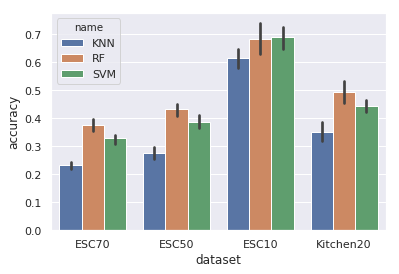

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df_results = np.load('./results.pkl')
# df_results[['accuracy', 'name', 'dataset', 'fold']]
# for dataset_name in [ds.__class__.__name__ for ds in datasets]:
#     print(dataset_name)
#     mask = (df_results.dataset == dataset_name) & (df_results.fold != -1)
#     sns.barplot(x='name', y='accuracy', hue='fold', 
#                 data=df_results[mask])
#     plt.show()


sns.barplot(x='dataset', y='accuracy', hue='name', data=df_results[df_results.fold != -1])
plt.show()

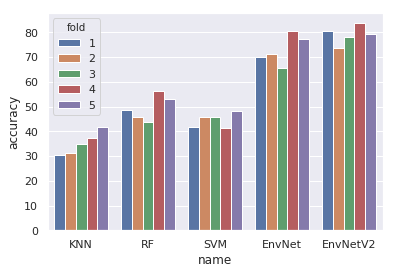

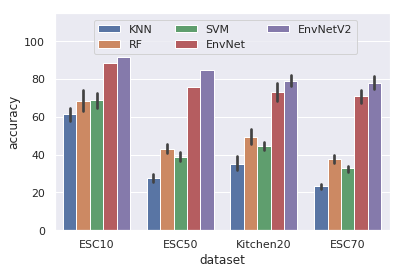

In [92]:
df_results_cnn = df_results.copy()
for row in [
    {'dataset': 'ESC10',     'name': 'EnvNet',   'accuracy': 1 - 0.113, 'fold': -2},
    {'dataset': 'ESC10',     'name': 'EnvNetV2', 'accuracy': 1 - 0.086, 'fold': -2},
    {'dataset': 'ESC50',     'name': 'EnvNet',   'accuracy': 1 - 0.241, 'fold': -2},
    {'dataset': 'ESC50',     'name': 'EnvNetV2', 'accuracy': 1 - 0.151, 'fold': -2},

    {'dataset': 'ESC70',     'name': 'EnvNet',   'accuracy': 1 - .269, 'fold': 1},
    {'dataset': 'ESC70',     'name': 'EnvNet',   'accuracy': 1 - .319, 'fold': 2},
    {'dataset': 'ESC70',     'name': 'EnvNet',   'accuracy': 1 - .350, 'fold': 3},
    {'dataset': 'ESC70',     'name': 'EnvNet',   'accuracy': 1 - .244, 'fold': 4},
    {'dataset': 'ESC70',     'name': 'EnvNet',   'accuracy': 1 - .256, 'fold': 5},
    {'dataset': 'ESC70',     'name': 'EnvNet',   'accuracy': 1 - .287, 'fold': -1},

    {'dataset': 'ESC70',     'name': 'EnvNetV2', 'accuracy': 1 - .250, 'fold': 1},
    {'dataset': 'ESC70',     'name': 'EnvNetV2', 'accuracy': 1 - .238, 'fold': 2},
    {'dataset': 'ESC70',     'name': 'EnvNetV2', 'accuracy': 1 - .269, 'fold': 3},
    {'dataset': 'ESC70',     'name': 'EnvNetV2', 'accuracy': 1 - .163, 'fold': 4},
    {'dataset': 'ESC70',     'name': 'EnvNetV2', 'accuracy': 1 - .175, 'fold': 5},
    {'dataset': 'ESC70',     'name': 'EnvNetV2', 'accuracy': 1 - .219, 'fold': -1},

    {'dataset': 'Kitchen20', 'name': 'EnvNet',   'accuracy': 1 - .300, 'fold': 1},
    {'dataset': 'Kitchen20', 'name': 'EnvNet',   'accuracy': 1 - .288, 'fold': 2},
    {'dataset': 'Kitchen20', 'name': 'EnvNet',   'accuracy': 1 - .344, 'fold': 3},
    {'dataset': 'Kitchen20', 'name': 'EnvNet',   'accuracy': 1 - .194, 'fold': 4},
    {'dataset': 'Kitchen20', 'name': 'EnvNet',   'accuracy': 1 - .225, 'fold': 5},
    {'dataset': 'Kitchen20', 'name': 'EnvNet',   'accuracy': 1 - .270, 'fold': -1},

    {'dataset': 'Kitchen20', 'name': 'EnvNetV2', 'accuracy': 1 - .194, 'fold': 1},
    {'dataset': 'Kitchen20', 'name': 'EnvNetV2', 'accuracy': 1 - .263, 'fold': 2},
    {'dataset': 'Kitchen20', 'name': 'EnvNetV2', 'accuracy': 1 - .219, 'fold': 3},
    {'dataset': 'Kitchen20', 'name': 'EnvNetV2', 'accuracy': 1 - .163, 'fold': 4},
    {'dataset': 'Kitchen20', 'name': 'EnvNetV2', 'accuracy': 1 - .206, 'fold': 5},
    {'dataset': 'Kitchen20', 'name': 'EnvNetV2', 'accuracy': 1 - .209, 'fold': -1}]:
        df_results_cnn = df_results_cnn.append(row, ignore_index=True)


df_results_cnn.fold = df_results_cnn.fold.astype(int)
df_results_cnn.accuracy = df_results_cnn.accuracy * 100


mask = (df_results_cnn.dataset == 'Kitchen20') & (df_results_cnn.fold != -1)
sns.barplot(x='name', y='accuracy', hue='fold',
            data=df_results_cnn[mask])
plt.show()

        
lm = sns.barplot(x='dataset', y='accuracy', hue='name', order=['ESC10','ESC50','Kitchen20','ESC70'],
                data=df_results_cnn[df_results_cnn.fold != -1])
plt.legend(loc='lower left', bbox_to_anchor=(0.1, .785), ncol=3)
lm.axes.set_ylim(0, 115)
plt.show()

In [305]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

df_true = pd.DataFrame()
for dataset in datasets:
    df = dataset_to_df(dataset)
    df_name = dataset.__class__.__name__
    for fold in range(1, 6):
        df_true = df_true.append({
            'dataset': df_name,
            'fold': fold,
            'true': df[df['fold'] == fold]['category'].as_matrix()
        }, ignore_index=True)

In [247]:
df_results.loc[(df_results.fold == -1) & (df_results.dataset == 'ESC70')]

,C,accuracy,criterion,fold,gamma,kernel,max_depth,max_features,n_estimators,n_neighbors,name,pred,dataset,recall
5,NaN,0.235000,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,10.0,KNN,NaN,ESC70,-1
11,NaN,0.376429,gini,-1.0,NaN,NaN,17.0,3.0,980.0,NaN,RF,NaN,ESC70,-1
17,0.02349,0.329286,NaN,-1.0,1.765695,linear,NaN,NaN,NaN,NaN,SVM,NaN,ESC70,-1


In [231]:
df_results['recall'] = np.array(-1).astype(object)
for idx, row in df_results.iterrows():
    if row.fold != -1:
        mask_row = (df_true.fold == row.fold) & (df_true.dataset == row.dataset)
        y = df_true[mask_row].true.as_matrix()[0]
        recall = recall_score(y, row.pred, average=None)
        df_results.at[idx, 'recall'] = recall
        
'''I should use the recall somehow'''

In [190]:
import torch
from torch import nn
from kitchen20 import esc
import kitchen20.utils as U

k20_train = esc.Kitchen20(
    folds=[1, 2, 3, 4],
    audio_rate=16000,
    transforms=[
        U.padding(inputLength // 2),  # Padding
        U.random_scale(1.25),  # Random augment
        U.random_crop(16000),  # Random crop
        U.normalize(float(2 ** 16 / 2))  # 16 bit signed
    ])  

k20_val = esc.Kitchen20(
    folds=[5],
    audio_rate=16000,
    transforms=[
        U.random_crop(16000),  # Random crop
        U.normalize(float(2 ** 16 / 2))
    ])  # 16 bit signed


trainloader = torch.utils.data.DataLoader(
    k20_train, batch_size=32, shuffle=True)

testloader = torch.utils.data.DataLoader(
    k20_train, batch_size=32, shuffle=True)

net = myNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_and_test()

nn.Sequential(
    nn.Conv1d(1,  32, kernel_size=16, stride=6),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Conv1d(32, 20, kernel_size=16, stride=6),
    nn.AvgPool1d(447))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for _ in range(100):
    loss_sum = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs = inputs[:, None, :]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)[:,:,0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss
    print(loss_sum)

NameError: name 'inputLength' is not defined

In [167]:
net = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=50, kernel_size=16, stride=6), nn.ReLU(),
    nn.Conv1d(in_channels=50, out_channels=20, kernel_size=16, stride=6), nn.AvgPool1d(447))


inputs.shape, net(inputs)[:,:,0].shape
labels.float()

tensor([ 5., 18., 46., 15., 26., 10., 43., 15., 47., 18., 34., 49., 36., 44.,
         8., 24., 41., 43.,  4., 13., 20., 11., 25., 12.,  1., 32., 44.,  0.,
        36.,  6., 20., 10.])